# Introduction to Vertex Pipelines



## Learning Objectives

1. Use the Kubeflow Pipelines SDK to build scalable ML pipelines.

2. Create and run a 3-step intro pipeline that takes text input.



## Introduction 

In this notebook, you will learn how to create and run ML pipelines with Vertex Pipelines.


Each learning objective will correspond to a __#TODO__ in the [student lab notebook](../labs/intro_to_vertex_pipelines.ipynb) -- try to complete that notebook first before reviewing this solution notebook.






# Vertex Pipelines setup

There are a few additional libraries we'll need to install in order to use Vertex Pipelines:

* **Kubeflow Pipelines**: This is the SDK we'll be using to build our pipeline. Vertex Pipelines supports running pipelines built with both Kubeflow Pipelines or TFX.

* **Google Cloud Pipeline Components**: This library provides pre-built components that make it easier to interact with Vertex AI services from your pipeline steps.


### Step 1: Install necessary libraries

To install both services we'll be using in this lab, first set the user flag in a notebook cell:

In [1]:
USER_FLAG = "--user"

Then run the following from your notebook:

In [2]:
# Install necessary libraries
!pip3 install {USER_FLAG} google-cloud-aiplatform==1.0.0 --upgrade
!pip3 install {USER_FLAG} kfp google-cloud-pipeline-components==0.1.1 --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.3/93.3 KB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 KB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.9/152.9 KB 20.5 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cloud-tpu-client 0.10 requires google-api-python-client==1.8.0, but you have google-api-python-client 2.36.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.6/298.6 KB 7.6 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.6/636.6 KB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Please ignore any compatibility warnings and errors.


After installing these packages you'll need to restart the kernel:

In [1]:
# Load necessary libraries
import os
if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

Finally, check that you have correctly installed the packages. **The KFP SDK version should be >=1.6**:

In [1]:
# print KFP SDK version
!python3 -c "import kfp; print('KFP SDK version: {}'.format(kfp.__version__))"
!python3 -c "import google_cloud_pipeline_components; print('google_cloud_pipeline_components version: {}'.format(google_cloud_pipeline_components.__version__))"

KFP SDK version: 1.8.11
google_cloud_pipeline_components version: 0.1.1


### Step 2: Set your project ID and bucket

Throughout this lab you'll reference your Cloud project ID and the bucket you created earlier. Next we'll create variables for each of those.

If you don't know your project ID you may be able to get it by running the following:

In [2]:
import os
PROJECT_ID = ""
# Get your Google Cloud project ID from gcloud
if not os.getenv("IS_TESTING"):
    shell_output=!gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID: ", PROJECT_ID)

Project ID:  cloud-training-prod-bucket


Otherwise, set it here:

In [ ]:
if PROJECT_ID == "" or PROJECT_ID is None:
    PROJECT_ID = "your-project-id"  # @param {type:"string"}

Then create a variable to store your bucket name. If you created it in this lab, the following will work. Otherwise, you'll need to set this manually:

In [3]:
BUCKET_NAME="gs://" + PROJECT_ID + "-bucket"

### Step 3: Import libraries

Add the following to import the *libraries* we'll be using throughout this lab:

In [4]:
# Load necessary libraries
from typing import NamedTuple
import kfp
from kfp import dsl
from kfp.v2 import compiler
from kfp.v2.dsl import (Artifact, Dataset, Input, InputPath, Model, Output,
                        OutputPath, ClassificationMetrics, Metrics, component)
from kfp.v2.google.client import AIPlatformClient
from google.cloud import aiplatform
from google_cloud_pipeline_components import aiplatform as gcc_aip

### Step 4: Define constants

The last thing we need to do before building our pipeline is define some constant variables. PIPELINE_ROOT is the Cloud Storage path where the artifacts created by our pipeline will be written. We're using us-central1 as the region here, but if you used a different region when you created your bucket, update the REGION variable in the code below:

In [5]:
PATH=%env PATH
%env PATH={PATH}:/home/jupyter/.local/bin
REGION="us-central1"
PIPELINE_ROOT = f"{BUCKET_NAME}/pipeline_root/"
PIPELINE_ROOT

env: PATH=/usr/local/cuda/bin:/opt/conda/bin:/opt/conda/condabin:/usr/local/bin:/usr/bin:/bin:/usr/local/games:/usr/games:/home/jupyter/.local/bin


'gs://cloud-training-prod-bucket-bucket/pipeline_root/'

After running the code above, you should see the root directory for your pipeline printed. This is the Cloud Storage location where the artifacts from your pipeline will be written. It will be in the format of gs://Your_Project_ID/pipeline_root/

# Creating your first pipeline

To get familiar with how Vertex Pipelines works, we'll first create a short pipeline using the KFP SDK. This pipeline doesn't do anything ML related (don't worry, we'll get there!), we're using it to teach you:

* How to create custom components in the KFP SDK
* How to run and monitor a pipeline in Vertex Pipelines

We'll create a pipeline that prints out a sentence using two outputs: a product name and an emoji description. This pipeline will consist of three components:

* **product_name**: This component will take a product name (or any noun you want really) as input, and return that string as output
* **emoji**: This component will take the text description of an emoji and convert it to an emoji. For example, the text code for ✨ is "sparkles". This component uses an emoji library to show you how to manage external dependencies in your pipeline
* **build_sentence**: This final component will consume the output of the previous two to build a sentence that uses the emoji. For example, the resulting output might be "Vertex Pipelines is ✨".

Let's start coding!

### Step 1: Create a Python function based component

Using the KFP SDK, we can create components based on Python functions. We'll use that for the 3 components in our first pipeline. We'll first build the **product_name** component, which simply takes a string as input and returns that string. Add the following to your notebook:

In [6]:
@component(base_image="python:3.9", output_component_file="first-component.yaml")
def product_name(text: str) -> str:
    return text

Let's take a closer look at the syntax here:

* The @component decorator compiles this function to a component when the pipeline is run. You'll use this anytime you write a custom component.

* The base_image parameter specifies the container image this component will use.

* The output_component_file parameter is optional, and specifies the yaml file to write the compiled component to. After running the cell you should see that file written to your notebook instance. If you wanted to share this component with someone, you could send them the generated yaml file and have them load it with the following:



In [7]:
# TODO
product_name_component = kfp.components.load_component_from_file('./first-component.yaml')

* The -> str after the function definition specifies the output type for this component.

### Step 2: Create two additional components

To complete our pipeline, we'll create two more components. The first one we'll define takes a string as input, and converts this string to its corresponding emoji if there is one. It returns a tuple with the input text passed, and the resulting [emoji](https://pypi.org/project/emoji/):

In [8]:
@component(packages_to_install=["emoji"])
def emoji(
    text: str,
) -> NamedTuple(
    "Outputs",
    [
        ("emoji_text", str),  # Return parameters
        ("emoji", str),
    ],
):
    import emoji
    emoji_text = text
    emoji_str = emoji.emojize(':' + emoji_text + ':', use_aliases=True)
    print("output one: {}; output_two: {}".format(emoji_text, emoji_str))
    return (emoji_text, emoji_str)

This component is a bit more complex than our previous one. Let's break down what's new:

* The packages_to_install parameter tells the component any external library dependencies for this container. In this case, we're using a library called emoji.
* This component returns a NamedTuple called Outputs. Notice that each of the strings in this tuple have keys: emoji_text and emoji. We'll use these in our next component to access the output.

The final component in this pipeline will consume the output of the first two and combine them to return a string:

In [13]:
@component
def build_sentence(
    product: str,
    emoji: str,
    emojitext: str
) -> str:
    print("We completed the pipeline, hooray!")
    end_str = product + " is "
    if len(emoji) > 0:
        end_str += emoji
    else:
        end_str += emojitext
    return(end_str)

You might be wondering: how does this component know to use the output from the previous steps you defined? Good question! We will tie it all together in the next step.

### Step 3: Putting the components together into a pipeline

The component definitions we defined above created factory functions that can be used in a pipeline definition to create steps. To set up a pipeline, use the @dsl.pipeline decorator, give the pipeline a name and description, and provide the root path where your pipeline's artifacts should be written. By artifacts, we mean any output files generated by your pipeline. This intro pipeline doesn't generate any, but our next pipeline will.

In the next block of code we define an intro_pipeline function. This is where we specify the inputs to our initial pipeline steps, and how steps connect to each other:

* product_task takes a product name as input. Here we're passing "Vertex Pipelines" but you can change this to whatever you'd like.

* emoji_task takes the text code for an emoji as input. You can also change this to whatever you'd like. For example, "party_face" refers to the 🥳 emoji. Note that since both this and the product_task component don't have any steps that feed input into them, we manually specify the input for these when we define our pipeline.

* The last step in our pipeline - consumer_task has three input parameters:

* The output of product_task. Since this step only produces one output, we can reference it via product_task.output.

* The emoji output of our emoji_task step. See the emoji component defined above where we named the output parameters.

* Similarly, the emoji_text named output from the emoji component. In case our pipeline is passed text that doesn't correspond with an emoji, it'll use this text to construct a sentence.

In [14]:
@dsl.pipeline(
    name="hello-world",
    description="An intro pipeline",
    pipeline_root=PIPELINE_ROOT,
)
# You can change the `text` and `emoji_str` parameters here to update the pipeline output
def intro_pipeline(text: str = "Vertex Pipelines", emoji_str: str = "sparkles"):
    product_task = product_name(text)
    emoji_task = emoji(emoji_str)
    consumer_task = build_sentence(
        product_task.output,
        emoji_task.outputs["emoji"],
        emoji_task.outputs["emoji_text"],
    )

### Step 4: Compile and run the pipeline

With your pipeline defined, you're ready to compile it. The following will generate a JSON file that you'll use to run the pipeline:

In [15]:
compiler.Compiler().compile(
    pipeline_func=intro_pipeline, package_path="intro_pipeline_job.json"
)

Next, instantiate an API client:

In [16]:
api_client = AIPlatformClient(
    project_id=PROJECT_ID,
    region=REGION,
)

/home/jupyter/.local/lib/python3.7/site-packages/kfp/v2/google/client/client.py:173: FutureWarning: AIPlatformClient will be deprecated in v2.0.0. Please use PipelineJob https://googleapis.dev/python/aiplatform/latest/_modules/google/cloud/aiplatform/pipeline_jobs.html in Vertex SDK. Install the SDK using "pip install google-cloud-aiplatform"
  category=FutureWarning,


Finally, run the pipeline:

In [17]:
# TODO
response = api_client.create_run_from_job_spec(
    job_spec_path="intro_pipeline_job.json",
    # pipeline_root=PIPELINE_ROOT  # this argument is necessary if you did not specify PIPELINE_ROOT as part of the pipeline definition.
)

Running the pipeline should generate a link to view the pipeline run in your console. It should look like this when complete:

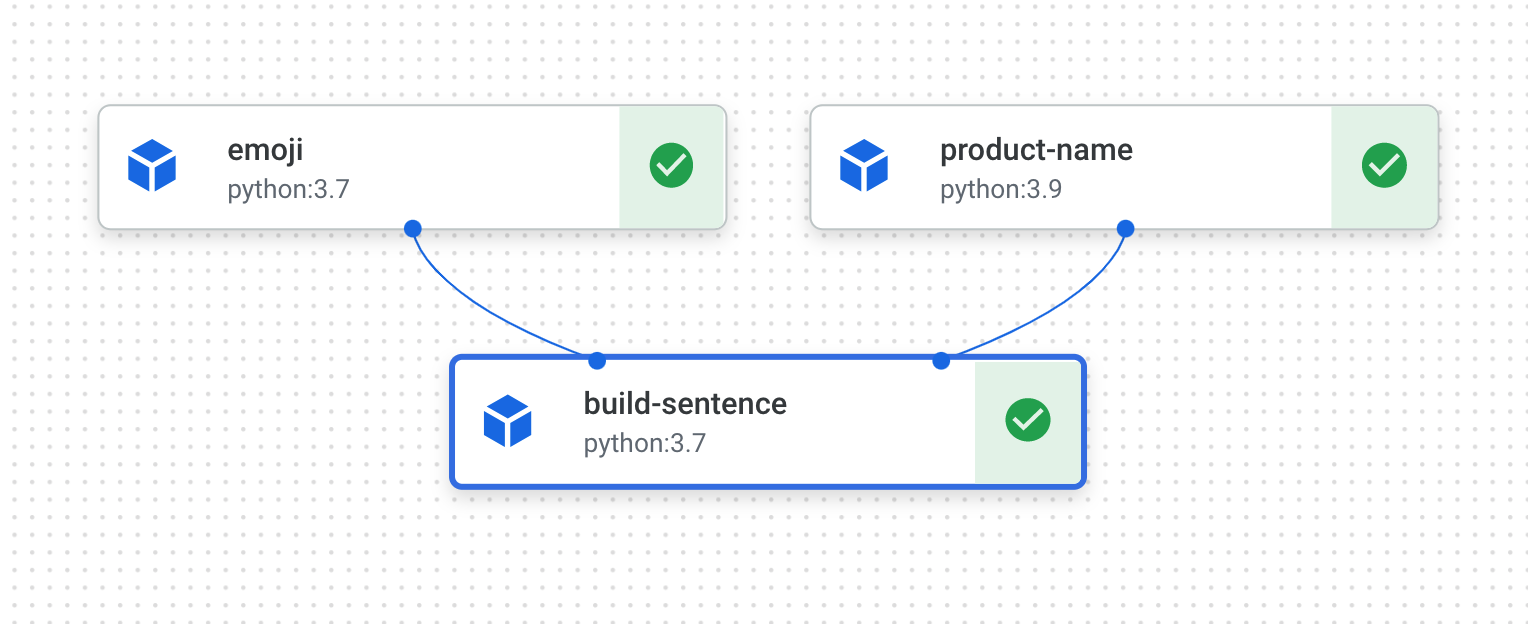

This pipeline will take **5-6 minutes** to run. When complete, you can click on the build-sentence component to see the final output:

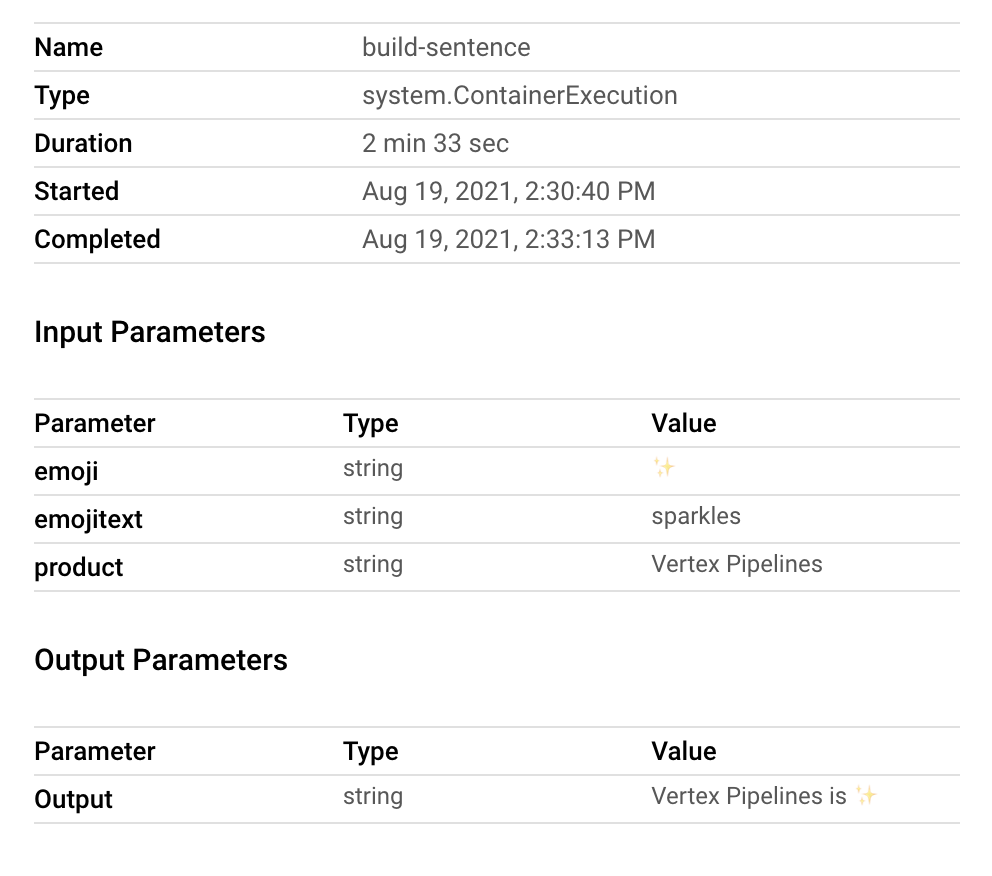

Now that you're familiar with how the KFP SDK and Vertex Pipelines works, you're ready to build a pipeline that creates and deploys an ML model using other Vertex AI services. Be sure to do try the next lab, Create and run ML pipelines with Vertex Pipelines! 